In [712]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import pandas as pd
from collections import Counter
from ast import literal_eval
import itertools
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from operator import itemgetter 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import cross_validation

In [577]:
PATH_TO_TRAIN = "../../data/train.tsv"
PATH_TO_TEST = "../../data/public.tsv"
PATH_TO_VOCAB = "../../data/vocab.txt"

In [578]:
train_column_names = ['context_id', 'context_2', 'context_1', 
                           'context_0', 'reply_id', 'reply', 'label', 'confidence']

In [579]:
test_column_names = ['context_id', 'context_2', 'context_1', 
                           'context_0', 'reply_id', 'reply']

In [580]:
train = pd.read_csv(PATH_TO_TRAIN, error_bad_lines=False, sep = '[  . ? , !]?\t', 
                   header=None)
train.columns = train_column_names

/Users/kitashov/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [581]:
train.head()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence
0,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",0,не могу,good,0.875352
1,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",1,"нет , звонить буду я",neutral,0.900968
2,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",2,"слушай , я не мог уйти",bad,0.884320
3,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",3,я не прекращу звонить,good,0.982530
4,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",4,я звоню им,good,0.838054


## Number of utterances

In [41]:
line_stats_list = list(train.context_2.isnull() * 1 + train.context_1.isnull() * 1 + train.context_0.isnull() * 1)

In [42]:
line_stats_rangeindex = train.context_2.isnull() * 1 + train.context_1.isnull() * 1 + train.context_0.isnull() * 1

In [51]:
Counter(line_stats_rangeindex)

Counter({0: 48390, 1: 24082, 2: 25043, 3: 18})

In [49]:
nan_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 3].index

In [53]:
assert len(nan_lines_indices) == Counter(line_stats_rangeindex)[3]

In [50]:
single_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 2].index

In [54]:
assert len(single_lines_indices) == Counter(line_stats_rangeindex)[2]

In [55]:
two_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 1].index

In [56]:
assert len(two_lines_indices) == Counter(line_stats_rangeindex)[1]

In [57]:
three_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 0].index

## Get indices

In [229]:
def get_column_unique_lines(dataframe, column_name, indices):
    mask = np.roll(dataframe.loc[indices, column_name],1)!=dataframe.loc[indices,column_name]
    return list(mask[mask==True].index)

In [232]:
def get_dataframe_unique_lines(dataframe, indices):
    unique_lines = []
    context_2_unique_lines = get_column_unique_lines(dataframe, 'context_2', indices)
    context_1_unique_lines = get_column_unique_lines(dataframe, 'context_1', indices)
    context_0_unique_lines = get_column_unique_lines(dataframe, 'context_0', indices)
    #print (context_2_unique_lines[:5])
    #print (context_1_unique_lines[:5])
    #print (context_0_unique_lines[:5])
    for x in context_2_unique_lines:
        if x in context_1_unique_lines and x in context_0_unique_lines:
            unique_lines.append(x)
    return unique_lines

In [234]:
three_lines_unique_indices = get_dataframe_unique_lines(train, three_lines_indices)
two_lines_unique_indices = get_dataframe_unique_lines(train, two_lines_indices)
single_lines_unique_indices = get_dataframe_unique_lines(train, single_lines_indices)

In [235]:
print (three_lines_unique_indices[:5])
print (two_lines_unique_indices[:5])
print (single_lines_unique_indices[:5])

[0, 6, 12, 18, 24]
[61, 109, 115, 121, 139]
[49, 67, 91, 151, 175]


## Get train percentage

In [58]:
len(three_lines_indices) / len(line_stats_rangeindex)

0.4961397680784965

In [59]:
len(two_lines_indices) / len(line_stats_rangeindex)

0.24691130181579568

In [62]:
len(single_lines_indices) / len(line_stats_rangeindex)

0.2567643771851578

# Get test stats

In [63]:
test = pd.read_csv(PATH_TO_TEST, error_bad_lines=False, sep = '[  . ? , !]?\t', 
                   header=None)
test.columns = test_column_names

/Users/kitashov/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [64]:
test.head()

,context_id,context_2,context_1,context_0,reply_id,reply
0,138920940977,"знаешь , я иногда подумываю , что тебе надо пр...",не - а,нет,0,неа .
1,138920940977,"знаешь , я иногда подумываю , что тебе надо пр...",не - а,нет,1,"нет , не хочу ."
2,138920940977,"знаешь , я иногда подумываю , что тебе надо пр...",не - а,нет,2,нет .
3,138920940977,"знаешь , я иногда подумываю , что тебе надо пр...",не - а,нет,3,"конечно , нет ."
4,138920940977,"знаешь , я иногда подумываю , что тебе надо пр...",не - а,нет,4,"разумеется , нет ."


In [65]:
test_line_stats_list = list(test.context_2.isnull() * 1 + test.context_1.isnull() * 1 + test.context_0.isnull() * 1)

In [66]:
test_line_stats_rangeindex = test.context_2.isnull() * 1 + \
                    test.context_1.isnull() * 1 + test.context_0.isnull() * 1

In [67]:
Counter(test_line_stats_rangeindex)

Counter({0: 5022, 1: 2526, 2: 2420})

In [68]:
test_single_lines_indices = test_line_stats_rangeindex[test_line_stats_rangeindex == 2].index
test_two_lines_indices = test_line_stats_rangeindex[test_line_stats_rangeindex == 1].index
test_three_lines_indices = test_line_stats_rangeindex[test_line_stats_rangeindex == 0].index

In [71]:
len(test_single_lines_indices) / len(test_line_stats_rangeindex)

0.242776886035313

In [72]:
len(test_two_lines_indices) / len(test_line_stats_rangeindex)

0.25341091492776885

In [73]:
len(test_three_lines_indices) / len(test_line_stats_rangeindex)

0.5038121990369181

# Get test unique indices

In [236]:
test_three_lines_unique_indices = get_dataframe_unique_lines(test, test_three_lines_indices)
test_two_lines_unique_indices = get_dataframe_unique_lines(test, test_two_lines_indices)
test_single_lines_unique_indices = get_dataframe_unique_lines(test, test_single_lines_indices)

In [237]:
print (test_three_lines_unique_indices[:5])
print (test_two_lines_unique_indices[:5])
print (test_single_lines_unique_indices[:5])

[0, 6, 18, 48, 60]
[30, 78, 102, 108, 138]
[12, 24, 36, 42, 54]


## Words distribution

In [242]:
def get_filtered_words(dataset, indices, 
                       columns=['context_2', 'context_1', 'context_0']):
    lenghts = []
    for line in dataset.loc[indices, columns].values:
        filtered_words = ("".join(line[~pd.isnull(line)]).split())
        #print (filtered_words)
        lenghts.append(len(filtered_words))
    return lenghts

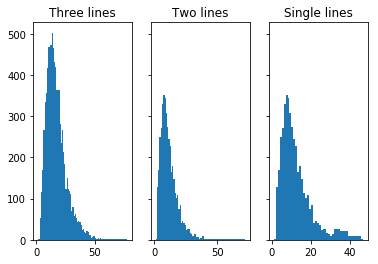

In [289]:
# get lenghts
x = get_filtered_words(train, three_lines_unique_indices)
y = get_filtered_words(train, two_lines_unique_indices)
z = get_filtered_words(train, single_lines_unique_indices)
fig, axs = plt.subplots(1, 3, sharey=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=list(Counter(x).keys()))
axs[1].hist(y, bins=list(Counter(y).keys()))
axs[2].hist(y, bins=list(Counter(z).keys()))

axs[0].title.set_text('Three lines')
axs[1].title.set_text('Two lines')
axs[2].title.set_text('Single lines')

plt.show()

In [591]:
def get_filtered_words(dataset, indices, 
                       columns=['context_2', 'context_1', 'context_0']):
    lenghts = []
    dataset.head()
    for line in dataset.loc[indices, columns].values:
        filtered_words = ("".join(line[~pd.isnull(line)]).split())
        lenghts.append(len(filtered_words))
    return lenghts

def get_column_unique_lines(dataframe, column_name, indices):
    mask = np.roll(dataframe.loc[indices, column_name],1)!=dataframe.loc[indices,column_name]
    return list(mask[mask==True].index)



def get_dataframe_unique_lines(dataframe, indices):
    unique_lines = []
    context_2_unique_lines = get_column_unique_lines(dataframe, 'context_2', indices)
    context_1_unique_lines = get_column_unique_lines(dataframe, 'context_1', indices)
    context_0_unique_lines = get_column_unique_lines(dataframe, 'context_0', indices)
    #print (context_2_unique_lines[:5])
    #print (context_1_unique_lines[:5])
    #print (context_0_unique_lines[:5])
    for x in context_2_unique_lines:
        if x in context_1_unique_lines and x in context_0_unique_lines:
            unique_lines.append(x)
    return unique_lines

def get_dataset_words_distribution(dataframe):
    
    line_stats_rangeindex = dataframe.context_2.isnull() * 1 + dataframe.context_1.isnull() * 1 + dataframe.context_0.isnull() * 1
    
    print (Counter(line_stats_rangeindex))
    
    single_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 2].index
    two_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 1].index
    three_lines_indices = line_stats_rangeindex[line_stats_rangeindex == 0].index
    
    print ('lines are counted')
    
    print ('Distribution:')
    print ('single lines', len(single_lines_indices) / len(line_stats_rangeindex))
    print ('two lines', len(two_lines_indices) / len(line_stats_rangeindex))
    print ('three lines', len(three_lines_indices) / len(line_stats_rangeindex))
    
    print ('----------------------------')
    
    
    three_lines_unique_indices = get_dataframe_unique_lines(dataframe, three_lines_indices)
    two_lines_unique_indices = get_dataframe_unique_lines(dataframe, two_lines_indices)
    single_lines_unique_indices = get_dataframe_unique_lines(dataframe, single_lines_indices)
    
    print ('unique lines are counted')
    
    num_unique_lines = len(three_lines_unique_indices) + len(two_lines_unique_indices) + len(single_lines_unique_indices)
    
    
    print ('Unique lines distribution:')
    print ('three lines', len(three_lines_unique_indices) / num_unique_lines)
    print ('two lines', len(two_lines_unique_indices) / num_unique_lines)
    print ('single lines', len(single_lines_unique_indices) / num_unique_lines)
    
    print ('-------------------------------------')

    x = get_filtered_words(dataframe, three_lines_unique_indices)
    print ('three lines filtered')
    y = get_filtered_words(dataframe, two_lines_unique_indices)
    print ('two lines filtered')
    z = get_filtered_words(dataframe, single_lines_unique_indices)
    print ('single lines filtered')
    
    print ('words are filtered')
    
    print ("Sizes:")
    print ('three lines', len(x))
    print ('two lines', len(y))
    print ('single line', len(z))
    
    print (len(x) + len(y) + len(z))
    
    print ("Average lenght:")
    print ('three lines', np.mean(x))
    print ('two lines', np.mean(y))
    print ('single lines', np.mean(z))
    
    print ("Median lenghts:")
    
    print ('three lines', np.percentile(x, 50))
    print ('two lines', np.percentile(y, 50))
    print ('single lines', np.percentile(z, 50))
    
    
    fig, axs = plt.subplots(1, 3, sharey=True)
    # We can set the number of bins with the `bins` kwarg
    axs[0].hist(x)
    axs[1].hist(y)
    axs[2].hist(z)


    axs[0].title.set_text('Three lines')
    axs[1].title.set_text('Two lines')
    axs[2].title.set_text('Single lines')

    plt.show()
    
    return three_lines_unique_indices, two_lines_unique_indices, single_lines_unique_indices,   \
                    np.mean(x), np.mean(y), np.mean(z), \
                        np.percentile(x, 50), np.percentile(y, 50), np.percentile(z, 50)

Counter({0: 48390, 2: 25043, 1: 24082, 3: 18})
lines are counted
Distribution:
single lines 0.2567643771851578
two lines 0.24691130181579568
three lines 0.4961397680784965
----------------------------
unique lines are counted
Unique lines distribution:
three lines 0.49784407411723575
two lines 0.24699918424426057
single lines 0.25515674163850366
-------------------------------------
three lines filtered
two lines filtered
single lines filtered
words are filtered
Sizes:
three lines 8544
two lines 4239
single line 4379
17162
Average lenght:
three lines 16.5980805243
two lines 10.971455532
single lines 5.56314226992
Median lenghts:
three lines 15.0
two lines 9.0
single lines 4.0


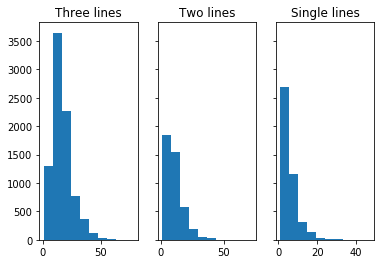

In [592]:
train_three_lines_unique_indices, train_two_lines_unique_indices, train_single_lines_unique_indices, train_mean_three_lines, train_mean_two_lines, train_mean_single_lines, train_median_three_lines, train_median_two_lines, train_median_single_lines = get_dataset_words_distribution(train)


Counter({0: 5022, 1: 2526, 2: 2420})
lines are counted
Distribution:
single lines 0.242776886035313
two lines 0.25341091492776885
three lines 0.5038121990369181
----------------------------
unique lines are counted
Unique lines distribution:
three lines 0.5026611472501479
two lines 0.25487876995860437
single lines 0.24246008279124778
-------------------------------------
three lines filtered
two lines filtered
single lines filtered
words are filtered
Sizes:
three lines 850
two lines 431
single line 410
1691
Average lenght:
three lines 16.9376470588
two lines 10.5475638051
single lines 5.6243902439
Median lenghts:
three lines 16.0
two lines 9.0
single lines 4.0


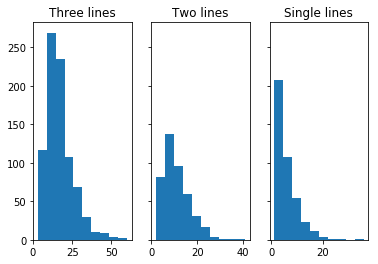

In [593]:
test_three_lines_unique_indices, test_two_lines_unique_indices, test_single_lines_unique_indices, test_mean_three_lines, test_mean_two_lines, test_mean_single_lines, test_median_three_lines, test_median_two_lines, test_median_single_lines = get_dataset_words_distribution(test)


# Check train

In [594]:
for i in train_three_lines_unique_indices:
    if i in train_two_lines_unique_indices or i in train_single_lines_unique_indices:
        print (i)

# Check test

In [595]:
for i in test_three_lines_unique_indices:
    if i in test_two_lines_unique_indices or i in test_single_lines_unique_indices:
        print (i)

## Unique lines

In [411]:
train.head()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence
0,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",0,не могу,good,0.875352
1,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",1,"нет , звонить буду я",neutral,0.900968
2,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",2,"слушай , я не мог уйти",bad,0.884320
3,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",3,я не прекращу звонить,good,0.982530
4,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",4,я звоню им,good,0.838054


In [412]:
len(train.context_id.unique())

17178

In [413]:
len(test.context_id.unique())

1694

In [414]:
len(test.context_id.unique()) / len(train.context_id.unique())

0.09861450692746536

In [415]:
len(test.context_id.unique()) / (len(train.context_id.unique()) - len(nan_lines_indices))

0.09871794871794871

## Train test split

## Train

In [597]:
print (len(train_three_lines_unique_indices))

8544


In [598]:
print (len(train_two_lines_unique_indices))

4239


In [599]:
print (len(train_single_lines_unique_indices))

4379


## Train test split debug

In [744]:
def train_test_split(dataframe, indices, test_size=0.2):
    y = get_filtered_words(dataframe, indices)
    values2drop = []
    for key, value in Counter(y).items():    # for name, age in list.items():  (for Python 3.x)
        if value == 1:
            values2drop.append(key)
            
    print (values2drop)

    valid_indices = [j for j, i in enumerate(y) if i not in values2drop]
    
    
    X = itemgetter(*valid_indices)(indices)
    
    print ('train size', len(X))
    
    print (X[:20])
    
    y = get_filtered_words(dataframe, X)
    
    print (y[:20])
    
    values2drop = []
    for key, value in Counter(y).items():    # for name, age in list.items():  (for Python 3.x)
        if value == 1:
            values2drop.append(key)

    print(values2drop)
    
    X = np.array(X)
    y = np.array(y)
    
    print (len(X))
    print (len(y))
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=test_size)
    
    
    
    '''
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    '''
    return X_train, X_test, y_train, y_test

In [745]:
three_X_train, three_X_test, three_y_train, three_y_test = train_test_split(train, train_three_lines_unique_indices)

[1, 51, 59, 65, 66, 73, 76, 78]
train size 8536
(0, 6, 12, 18, 24, 30, 31, 37, 43, 55, 73, 79, 85, 97, 103, 127, 133, 145, 157, 163)
[21, 27, 16, 10, 30, 18, 21, 4, 17, 11, 23, 7, 40, 33, 8, 37, 21, 5, 7, 13]
[]
8536
8536


In [746]:
Counter(Counter(three_X_train).values())

Counter({1: 6828})

In [747]:
Counter(Counter(three_X_test).values())

Counter({1: 1708})

### Thee lines test val split

In [748]:
three_X_test, three_X_val, _, _ = train_test_split(train, three_X_test, test_size=0.5)

[2, 47, 50, 52, 53, 54, 55]
train size 1701
(26686, 86648, 47885, 36178, 82364, 39722, 81277, 885, 24336, 38395, 14067, 80554, 67836, 71963, 84840, 47373, 40768, 77746, 35158, 78204)
[19, 16, 12, 14, 18, 18, 23, 11, 19, 21, 11, 15, 18, 23, 13, 17, 5, 24, 15, 15]
[]
1701
1701


In [749]:
Counter(Counter(three_X_test).values())

Counter({1: 850})

In [750]:
Counter(Counter(three_X_val).values())

Counter({1: 851})

# Two lines

In [751]:
two_X_train, two_X_test, two_y_train, two_y_test = train_test_split(train, train_two_lines_unique_indices, test_size=0.2)

[41, 42, 43, 44, 46, 49, 55, 61, 72]
train size 4230
(61, 109, 115, 121, 139, 183, 202, 220, 226, 245, 263, 269, 314, 356, 368, 410, 428, 435, 453, 465)
[6, 16, 4, 8, 14, 7, 4, 20, 10, 3, 7, 11, 4, 8, 6, 6, 11, 7, 6, 10]
[]
4230
4230


In [752]:
Counter(Counter(two_X_train).values())

Counter({1: 3384})

In [753]:
Counter(Counter(two_X_test).values())

Counter({1: 846})

## Test Val split

In [754]:
two_X_test, two_X_val, _, _ = train_test_split(train, two_X_test, test_size=0.5)

[1, 33, 34, 35, 36, 37, 39, 40]
train size 838
(42779, 23362, 52958, 85458, 34226, 50281, 73003, 81938, 93126, 82138, 37270, 56400, 34794, 51192, 56808, 57675, 8384, 32264, 72710, 67176)
[3, 13, 17, 3, 14, 10, 8, 12, 5, 11, 4, 12, 12, 21, 18, 5, 14, 9, 7, 23]
[]
838
838


In [755]:
Counter(Counter(two_X_test).values())

Counter({1: 419})

In [756]:
Counter(Counter(two_X_val).values())

Counter({1: 419})

## Single lines

In [757]:
single_X_train, single_X_test, single_y_train, single_y_test = train_test_split(train, train_single_lines_unique_indices)

[29, 31, 35, 39, 46, 47]
train size 4373
(49, 67, 91, 151, 175, 195, 196, 302, 308, 320, 326, 374, 398, 416, 422, 459, 471, 477, 507, 525)
[5, 5, 2, 1, 3, 3, 5, 10, 3, 5, 3, 26, 5, 1, 4, 7, 2, 8, 8, 4]
[]
4373
4373


In [758]:
single_X_test, single_X_val, _, _ = train_test_split(train, single_X_test, test_size=0.5)

[22, 24, 26, 27, 28]
train size 870
(17601, 6528, 25294, 73946, 24675, 79681, 64044, 50091, 22113, 78102, 70231, 6473, 22654, 24837, 85768, 20730, 77800, 88207, 63418, 758)
[1, 5, 1, 4, 15, 9, 1, 12, 3, 14, 2, 4, 6, 1, 9, 1, 1, 4, 3, 1]
[]
870
870


In [759]:
X_train = np.concatenate([three_X_train, two_X_train, single_X_train], axis=0)
X_test = np.concatenate([three_X_test, two_X_test, single_X_test], axis=0)
X_val = np.concatenate([three_X_val, two_X_val, single_X_val])

In [760]:
len(X_train)

13710

In [761]:
len(X_test)

1704

In [762]:
len(X_val)

1705

## Check train_test_split

In [763]:
train_X_train = train.loc[X_train]
train_X_test = train.loc[X_test]
train_X_val = train.loc[X_val]

In [766]:
Counter(Counter(X_test).values())

Counter({1: 1704})

In [768]:
Counter(Counter(X_val).values())

Counter({1: 1705})

In [769]:
Counter(Counter(X_train).values())

Counter({1: 13710})

In [770]:
train_X_train.shape

(13710, 8)

In [771]:
train_X_test.shape

(1704, 8)

In [772]:
train_X_train.drop_duplicates().shape

(13710, 8)

In [773]:
train_X_test.drop_duplicates().shape

(1704, 8)

In [774]:
train_X_val.drop_duplicates().shape

(1705, 8)

Counter({0: 850, 2: 435, 1: 419})
lines are counted
Distribution:
single lines 0.25528169014084506
two lines 0.24589201877934272
three lines 0.4988262910798122
----------------------------
unique lines are counted
Unique lines distribution:
three lines 0.49853200234879624
two lines 0.24603640634174986
single lines 0.2554315913094539
-------------------------------------
three lines filtered
two lines filtered
single lines filtered
words are filtered
Sizes:
three lines 849
two lines 419
single line 435
1703
Average lenght:
three lines 16.5359246172
two lines 10.7136038186
single lines 5.33103448276
Median lenghts:
three lines 15.0
two lines 9.0
single lines 4.0


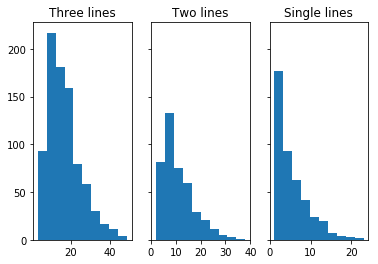

In [775]:
_, _, _, _, _, _, _, _, _  = get_dataset_words_distribution(train_X_test)

Counter({0: 851, 2: 435, 1: 419})
lines are counted
Distribution:
single lines 0.25513196480938416
two lines 0.24574780058651027
three lines 0.4991202346041056
----------------------------
unique lines are counted
Unique lines distribution:
three lines 0.4997060552616108
two lines 0.24514991181657847
single lines 0.2551440329218107
-------------------------------------
three lines filtered
two lines filtered
single lines filtered
words are filtered
Sizes:
three lines 850
two lines 417
single line 434
1701
Average lenght:
three lines 16.3176470588
two lines 10.6882494005
single lines 5.41705069124
Median lenghts:
three lines 15.0
two lines 9.0
single lines 4.0


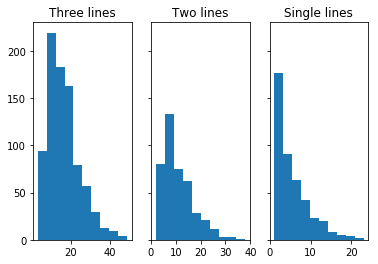

In [776]:
_, _, _, _, _, _, _, _, _  = get_dataset_words_distribution(train_X_val)

Counter({0: 6828, 2: 3498, 1: 3384})
lines are counted
Distribution:
single lines 0.2551422319474836
two lines 0.24682713347921226
three lines 0.49803063457330415
----------------------------
unique lines are counted
Unique lines distribution:
three lines 0.4979934330536301
two lines 0.24684421743889093
single lines 0.255162349507479
-------------------------------------
three lines filtered
two lines filtered
single lines filtered
words are filtered
Sizes:
three lines 6825
two lines 3383
single line 3497
13705
Average lenght:
three lines 16.5676190476
two lines 10.8909252143
single lines 5.52902487847
Median lenghts:
three lines 15.0
two lines 9.0
single lines 4.0


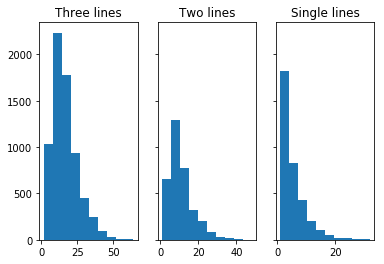

In [777]:
_, _, _, _, _, _, _, _, _ = get_dataset_words_distribution(train_X_train)

## Post prod

In [692]:
train.head()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence
0,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",0,не могу,good,0.875352
1,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",1,"нет , звонить буду я",neutral,0.900968
2,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",2,"слушай , я не мог уйти",bad,0.884320
3,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",3,я не прекращу звонить,good,0.982530
4,22579918886,"кликни на меня а потом на надпись "" видео - зв...","о , я тебя вижу","ладно , повесь трубку",4,я звоню им,good,0.838054


In [694]:
train_ids = train.loc[X_train, 'context_id']

In [705]:
test_ids = train.loc[X_test, 'context_id']

In [778]:
val_ids = train.loc[X_test, 'context_id']

In [779]:
train_ids[:5]

42936    122972060819979
79113    227815806974925
14869     43280525357343
85558    246371230461311
59490    171537718659898
Name: context_id, dtype: int64

In [780]:
test_ids[:5]

52497    151124827161979
3283       9004898342942
34921    100303766778736
13742     39278743908560
48079    138319279533738
Name: context_id, dtype: int64

In [781]:
val_ids[:5]

25976     74984696500671
74133    213588279969427
41696    119441101723137
54348    156489441529428
40768    116960665486446
Name: context_id, dtype: int64

In [704]:
train.loc[train['context_id'].isin(train_ids)].shape

(87523, 8)

In [706]:
train.loc[train['context_id'].isin(test_ids)].shape

(9795, 8)

In [782]:
train.loc[train['context_id'].isin(val_ids)].shape

(9644, 8)

## Save the split

In [783]:
np.save("../../data/train_context_ids.npy", train_ids)

In [784]:
np.save("../../data/test_context_ids.npy", test_ids)

In [785]:
np.save("../../data/val_context_ids.npy", val_ids)

## Load split

In [786]:
uploaded_train_ids = np.load("../../data/train_context_ids.npy")

In [787]:
uploaded_train_ids

array([122972060819979, 227815806974925,  43280525357343, ...,
       172777330452897,  57131959800035,  96959218159365])